In [1]:
import logging
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
import random
import torch
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from collections import Counter
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import cv2
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [10]:
# Path configuration
train_folder = "../data-collection/UC_2-VisDrone/images/train/"
val_folder = "../data-collection/UC_2-VisDrone/images/val/"
test_folder = "../data-collection/UC_2-VisDrone/images/test/"
train_labels_folder = '../data-collection/UC_2-VisDrone/labels/train/'
val_labels_folder = "../data-collection/UC_2-VisDrone/labels/val/"
test_labels_folder = "../data-collection/UC_2-VisDrone/labels/test/"

In [11]:
# List of valid image extensions
valid_extensions = ('.png', '.jpg', '.jpeg')

In [12]:
# Get list of image files in the train folder
image_files = [
    f for f in os.listdir(train_folder)
    if os.path.isfile(os.path.join(train_folder, f)) and f.lower().endswith(valid_extensions)
]

# Print the list of image files (optional)
print(image_files)

['0000002_00448_d_0000015.jpg', '0000007_05499_d_0000037.jpg', '0000007_05999_d_0000038.jpg', '0000008_02999_d_0000042.jpg', '0000008_04499_d_0000045.jpg', '0000010_05149_d_0000057.jpg', '0000016_00420_d_0000068.jpg', '0000016_01352_d_0000069.jpg', '0000030_00754_d_0000036.jpg', '0000031_00000_d_0000037.jpg', '0000031_02000_d_0000041.jpg', '0000039_00000_d_0000055.jpg', '0000040_02454_d_0000068.jpg', '0000040_03752_d_0000070.jpg', '0000042_01000_d_0000074.jpg', '0000043_00500_d_0000077.jpg', '0000045_00500_d_0000084.jpg', '0000045_01500_d_0000086.jpg', '0000046_00000_d_0000087.jpg', '0000048_01989_d_0000098.jpg', '0000068_00001_d_0000001.jpg', '0000068_00460_d_0000002.jpg', '0000068_01001_d_0000004.jpg', '0000068_03174_d_0000009.jpg', '0000068_03388_d_0000010.jpg', '0000068_03581_d_0000011.jpg', '0000068_03714_d_0000012.jpg', '0000070_04722_d_0000001.jpg', '0000071_03281_d_0000004.jpg', '0000071_03470_d_0000005.jpg', '0000071_06896_d_0000010.jpg', '0000071_06967_d_0000011.jpg', '000007

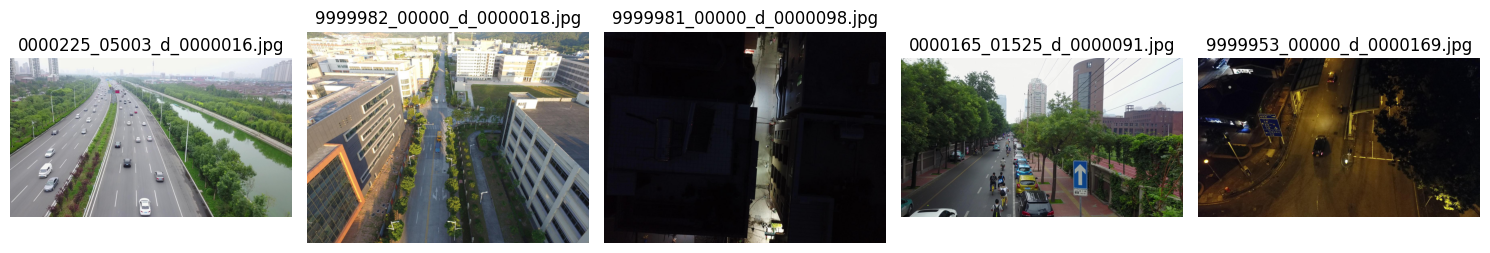

In [13]:
# Number of random images to select
num_random_images = 5

# Select random images
random_images = random.sample(image_files, num_random_images)

# Display the random images
fig, axes = plt.subplots(1, num_random_images, figsize=(15, 5))
for ax, img_file in zip(axes, random_images):
    img_path = os.path.join(train_folder, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_file)

plt.tight_layout()
plt.show()

In [14]:
# Function to read the labels from a directory
def read_labels_from_dir(label_dir):
    labels = {}
    for file_name in os.listdir(label_dir):
        file_path = os.path.join(label_dir, file_name)
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 2:
                    image_name, label = parts
                    labels[image_name] = label
    return labels

train_labels_dict = read_labels_from_dir(train_labels_folder)
val_labels_dict = read_labels_from_dir(val_labels_folder)
test_labels_dict = read_labels_from_dir(test_labels_folder)


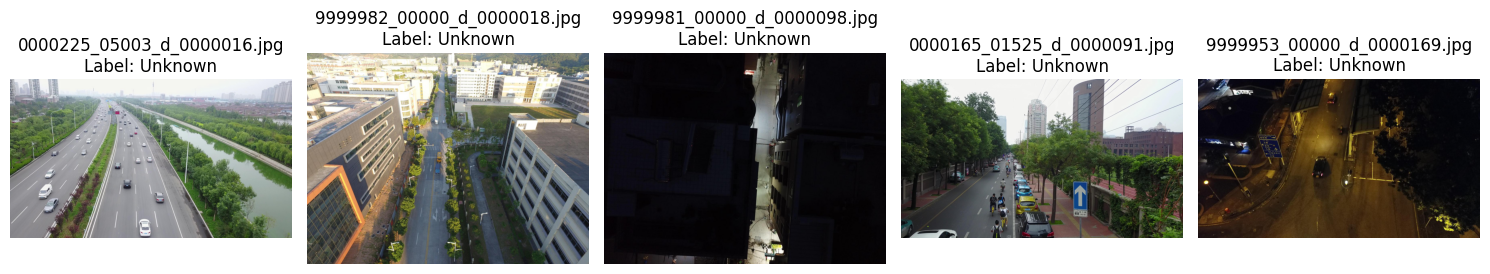

In [15]:
# Function to display the labels for the selected random images
def display_images_with_labels(image_folder, image_files, labels_dict):
    num_images = len(image_files)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for ax, img_file in zip(axes, image_files):
        img_path = os.path.join(image_folder, img_file)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        label = labels_dict.get(img_file, 'Unknown')
        ax.set_title(f"{img_file}\nLabel: {label}")
    plt.tight_layout()
    plt.show()

# Display the random images with their labels
display_images_with_labels(train_folder, random_images, train_labels_dict)

In [16]:
# Define the categories
categories = {
    0: 'pedestrian',
    1: 'people',
    2: 'bicycle',
    3: 'car',
    4: 'van',
    5: 'truck',
    6: 'tricycle',
    7: 'awning-tricycle',
    8: 'bus',
    9: 'motor'
}

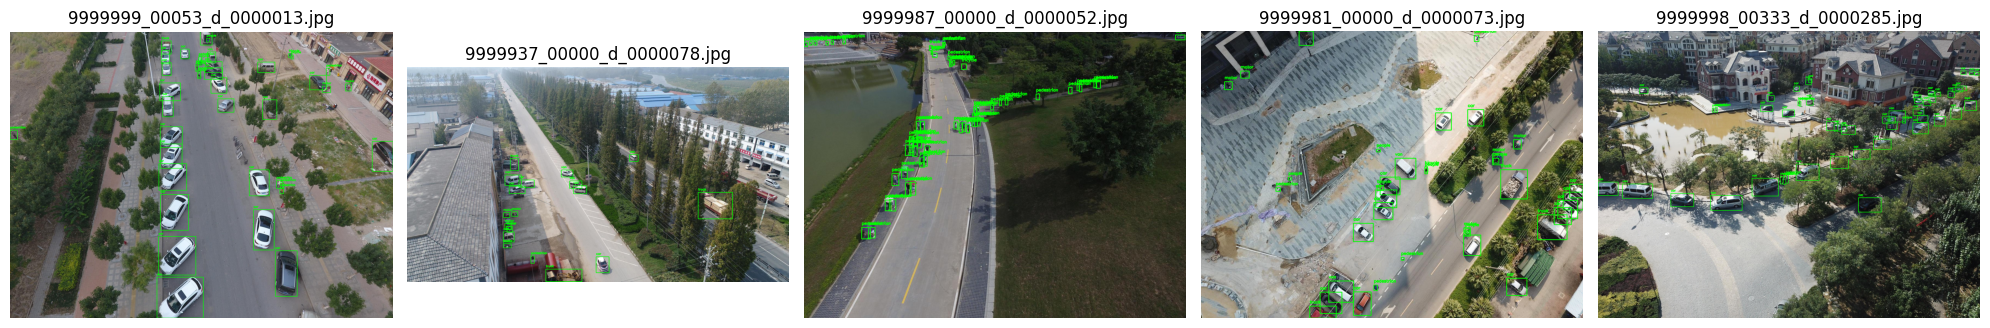

In [17]:
# Shuffle the image files to ensure randomness
random.shuffle(image_files)

# Select random images
random_images = image_files[:num_random_images]


# Function to draw bounding boxes and annotations on an image
def draw_boxes(img, annotation_file):
    image_height, image_width, _ = img.shape
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        values = list(map(float, line.strip().split(' ')))
        cls, x, y, w, h = values
        x = int((x - w / 2) * image_width)
        y = int((y - h / 2) * image_height)
        w = int(w * image_width)
        h = int(h * image_height)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        category = categories.get(int(cls), 'Unknown')
        cv2.putText(img, category, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return img


# Display the random images with bounding boxes
fig, axes = plt.subplots(1, num_random_images, figsize=(20, 5))
for ax, img_file in zip(axes, random_images):
    img_path = os.path.join(train_folder, img_file)
    img = cv2.imread(img_path)
    if img is not None:
        annotation_file = os.path.join(train_labels_folder, os.path.splitext(img_file)[0] + '.txt')
        if os.path.exists(annotation_file):
            img = draw_boxes(img, annotation_file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.axis('off')
        ax.set_title(img_file)
    else:
        ax.axis('off')
        ax.set_title(f"Image {img_file} not found")

plt.tight_layout()
plt.show()

In [18]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, labels_folder, transform=None):
        self.image_folder = image_folder
        self.labels_folder = labels_folder
        self.image_files = [
            f for f in os.listdir(image_folder)
            if os.path.isfile(os.path.join(image_folder, f)) and f.lower().endswith(valid_extensions)
        ]
        self.labels_dict = self.read_labels_from_dir(labels_folder)
        self.transform = transform

    def read_labels_from_dir(self, label_dir):
        labels = {}
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        image_name, label = parts
                        labels[image_name] = label
        return labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels_dict.get(img_name, 'Unknown')
        return image, label

    def draw_boxes(self, img, annotation_file):
        image_height, image_width, _ = img.shape
        with open(annotation_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            values = list(map(float, line.strip().split(' ')))
            cls, x, y, w, h = values
            x = int((x - w / 2) * image_width)
            y = int((y - h / 2) * image_height)
            w = int(w * image_width)
            h = int(h * image_height)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            category = categories.get(int(cls), 'Unknown')
            cv2.putText(img, category, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        return img

    def display_random_images(self, num_images=5):
        random_images = random.sample(self.image_files, num_images)
        fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
        for ax, img_file in zip(axes, random_images):
            img_path = os.path.join(self.image_folder, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                annotation_file = os.path.join(self.labels_folder, os.path.splitext(img_file)[0] + '.txt')
                if os.path.exists(annotation_file):
                    img = self.draw_boxes(img, annotation_file)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img_rgb)
                ax.axis('off')
                ax.set_title(img_file)
            else:
                ax.axis('off')
                ax.set_title(f"Image {img_file} not found")
        plt.tight_layout()
        plt.show()




In [19]:
# Example usage
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(train_folder, train_labels_folder, transform=transform)
val_dataset = CustomDataset(val_folder, val_labels_folder, transform=transform)
test_dataset = CustomDataset(test_folder, test_labels_folder, transform=transform)



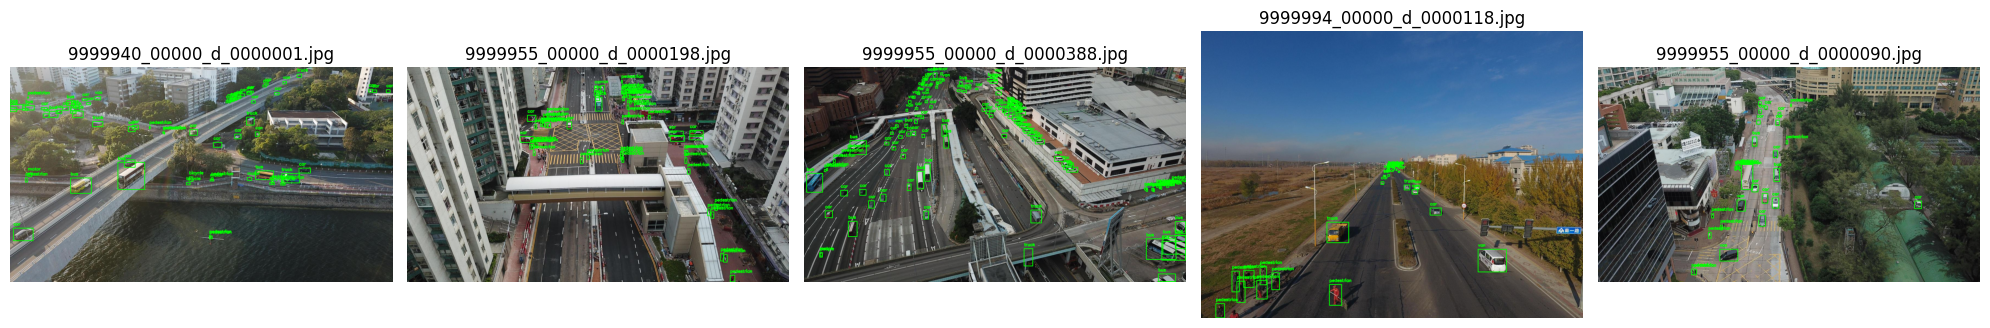

In [20]:
# Display random images from the training dataset
train_dataset.display_random_images(num_images=5)

# Creating a DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:
# Function to read labels from a file
def read_label(file_path):
    with open(file_path, 'r') as file:
        return file.read().strip()


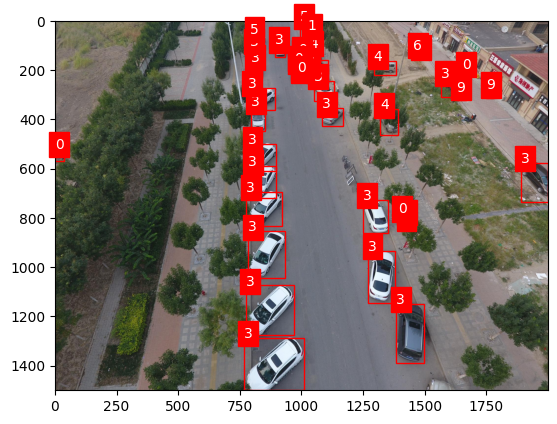

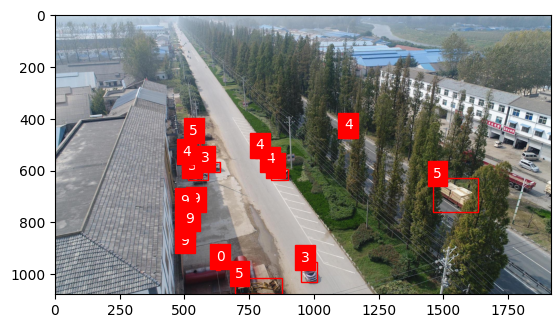

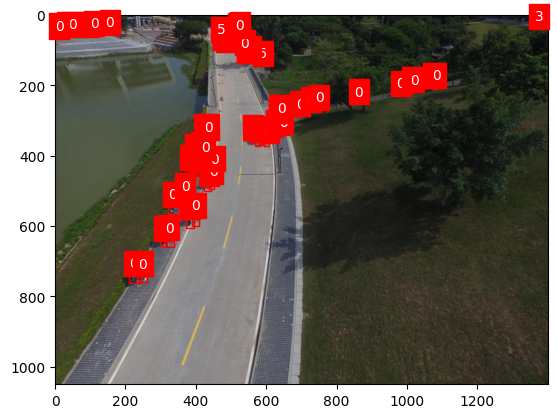

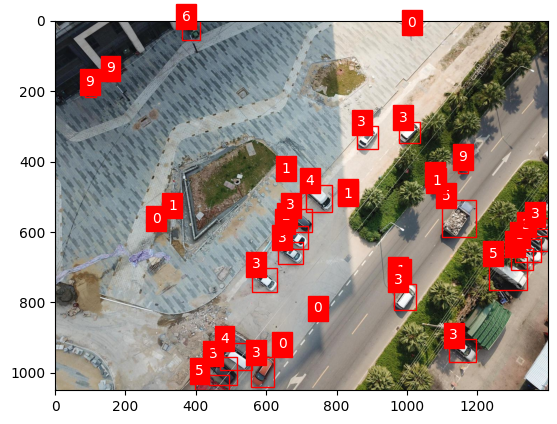

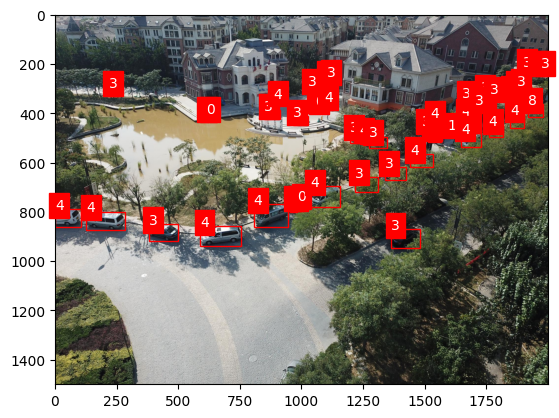

In [22]:
def plot_image_with_label(img_path, label):
    image = Image.open(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Assuming labels are in YOLO format: class x_center y_center width height
    for line in label.split('\n'):
        parts = line.split()
        if len(parts) == 5:
            cls, x_center, y_center, width, height = map(float, parts)
            x_center *= image.width
            y_center *= image.height
            width *= image.width
            height *= image.height
            x_min = x_center - width / 2
            y_min = y_center - height / 2

            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x_min, y_min, str(int(cls)), color='white', backgroundcolor='red')

    plt.show()

# Visualize random images with labels
for img_file in random_images:
    img_path = os.path.join(train_folder, img_file)
    label_file = os.path.splitext(img_file)[0] + '.txt'
    label_path = os.path.join(train_labels_folder, label_file)
    if os.path.exists(label_path):
        label = read_label(label_path)
        plot_image_with_label(img_path, label)
    else:
        print(f"Label file not found for {img_file}")

   class  x_center  y_center   width    height
0      3   0.72100  0.845000  0.0570  0.159333
1      3   0.66250  0.693000  0.0540  0.140667
2      3   0.65050  0.529333  0.0520  0.090667
3      3   0.56350  0.260333  0.0420  0.047333
4      3   0.54575  0.189667  0.0415  0.054000
class
3    44282
0    23842
9     8766
1     8644
4     7456
5     3781
2     3290
8     1725
6     1465
7     1024
Name: count, dtype: int64


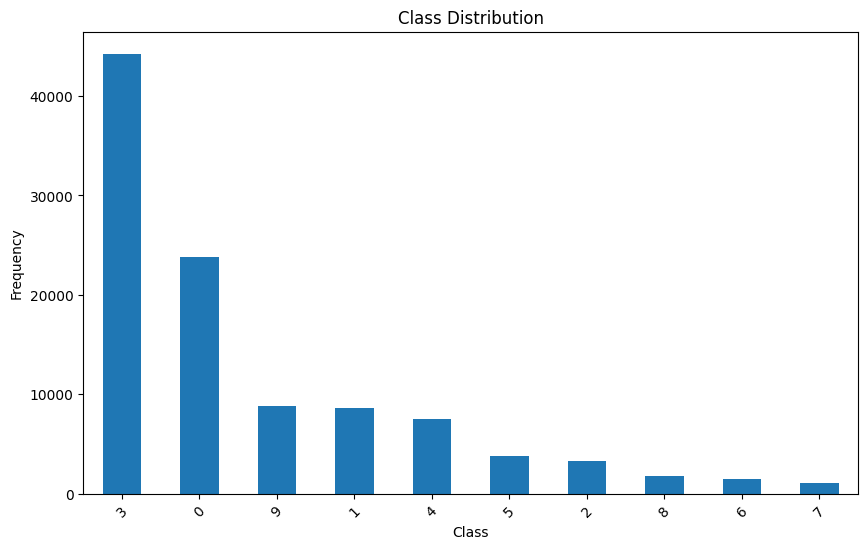

In [23]:
# Function to parse label data from YOLO format
def parse_label(label):
    parsed_labels = []
    for line in label.split('\n'):
        parts = line.split()
        if len(parts) == 5:
            cls, x_center, y_center, width, height = map(float, parts)
            parsed_labels.append((int(cls), x_center, y_center, width, height))
    return parsed_labels

# Collect all labels
all_labels = []
for img_file in image_files:
    label_file = os.path.splitext(img_file)[0] + '.txt'
    label_path = os.path.join(train_labels_folder, label_file)
    if os.path.exists(label_path):
        label = read_label(label_path)
        all_labels.extend(parse_label(label))

# Create DataFrame
df_labels = pd.DataFrame(all_labels, columns=['class', 'x_center', 'y_center', 'width', 'height'])
print(df_labels.head())

# Example analysis: Class distribution
class_counts = df_labels['class'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [98]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, labels_folder, transform=None):
        self.image_folder = image_folder
        self.labels_folder = labels_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
        self.labels_dict = self._load_labels()
        print(f"Loaded {len(self.image_files)} images.")
        print(f"Loaded labels for {len(self.labels_dict)} images.")
    
    def _load_labels(self):
        labels_dict = {}
        for label_file in os.listdir(self.labels_folder):
            label_path = os.path.join(self.labels_folder, label_file)
            with open(label_path, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    if len(parts) < 2:
                        print(f"Skipping invalid line in {label_file}: {line.strip()}")
                        continue
                    img_name = os.path.splitext(label_file)[0] + '.jpg'  # Assuming the images are in jpg format
                    label = parts[0]  # Using only the class_id
                    try:
                        labels_dict[img_name] = int(label)
                    except ValueError:
                        print(f"Invalid label for image {img_name} in {label_file}: {label}")
                        continue
        return labels_dict

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)  # Convert to tensor if no transform is applied
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            return None, None
        
        label = self.labels_dict.get(img_name, -1)  # Default to -1 if not found
        if label == -1:
            print(f"No label found for image {img_name}")
            return None, None
        
        return image, torch.tensor(label, dtype=torch.long)

    def custom_collate_fn(batch):
        # Filter out None values
        batch = [(image, label) for image, label in batch if image is not None and label is not None]
        
        if len(batch) > 0:
            images, labels = zip(*batch)
            
            # Stack images into a batch tensor
            images = torch.stack(images, dim=0)
            
            # Convert labels to tensor
            labels = torch.tensor(labels, dtype=torch.long)
            
            return images, labels
        else:
            return None, None
    def draw_boxes(self, img, annotation_file):
        image_height, image_width, _ = img.shape
        try:
            with open(annotation_file, 'r') as f:
                lines = f.readlines()
        except Exception as e:
            print(f"Error reading {annotation_file}: {e}")
            return img
        
        for line in lines:
            values = list(map(float, line.strip().split(' ')))
            cls, x, y, w, h = values
            x = int((x - w / 2) * image_width)
            y = int((y - h / 2) * image_height)
            w = int(w * image_width)
            h = int(h * image_height)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            category = categories.get(int(cls), 'Unknown')
            cv2.putText(img, category, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        return img

    def display_random_images(self, num_images=5):
        random_images = random.sample(self.image_files, num_images)
        fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
        for ax, img_file in zip(axes, random_images):
            img_path = os.path.join(self.image_folder, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                annotation_file = os.path.join(self.labels_folder, os.path.splitext(img_file)[0] + '.txt')
                if os.path.exists(annotation_file):
                    img = self.draw_boxes(img, annotation_file)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img_rgb)
                ax.axis('off')
                ax.set_title(img_file)
            else:
                ax.axis('off')
                ax.set_title(f"Image {img_file} not found")
        plt.tight_layout()
        plt.show()


In [99]:
def custom_collate_fn(batch):
    # Filter out None values
    batch = [(image, label) for image, label in batch if image is not None and label is not None]
    
    if len(batch) > 0:
        images, labels = zip(*batch)
        
        # Stack images into a batch tensor
        images = torch.stack(images, dim=0)
        
        # Convert labels to tensor
        labels = torch.tensor(labels, dtype=torch.long)
        
        return images, labels
    else:
        return None, None


# Dataset and DataLoader creation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(train_folder, train_labels_folder, transform=transform)
val_dataset = CustomDataset(val_folder, val_labels_folder, transform=transform)
test_dataset = CustomDataset(test_folder, test_labels_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True,collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True,collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True,collate_fn=custom_collate_fn)


Loaded 1942 images.
Loaded labels for 1942 images.
Loaded 165 images.
Loaded labels for 165 images.
Loaded 483 images.
Loaded labels for 483 images.


In [100]:
# Create a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [101]:
# Training function
def train_model(model, criterion, optimizer, dataloaders, num_epochs=25):
    device = torch.device("cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = dataloaders['train']
            else:
                model.eval()
                dataloader = dataloaders['val']

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                if inputs is None or labels is None:
                    print("Skipping batch due to missing inputs or labels")
                    continue  # Skip this batch

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()  # Accumulate correct predictions as integers

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects / len(dataloader.dataset)  # Compute accuracy from accumulated correct predictions

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

# Initialize the model, loss function, and optimizer
num_classes = len(categories)
model = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
dataloaders = {
    'train': train_loader,
    'val': val_loader
}
model = train_model(model, criterion, optimizer, dataloaders, num_epochs=25)

# Save the model
torch.save(model.state_dict(), 'simple_cnn.pth')


Epoch 0/24
----------
train Loss: 1.9987 Acc: 0.3290
val Loss: 1.9685 Acc: 0.3333

Epoch 1/24
----------
train Loss: 1.8800 Acc: 0.3435
val Loss: 1.9427 Acc: 0.2788

Epoch 2/24
----------
train Loss: 1.8521 Acc: 0.3471
val Loss: 1.9424 Acc: 0.2788

Epoch 3/24
----------
train Loss: 1.8490 Acc: 0.3522
val Loss: 1.9458 Acc: 0.2727

Epoch 4/24
----------
train Loss: 1.8271 Acc: 0.3568
val Loss: 1.9206 Acc: 0.3030

Epoch 5/24
----------
train Loss: 1.7703 Acc: 0.3738
val Loss: 1.9953 Acc: 0.3333

Epoch 6/24
----------
train Loss: 1.6508 Acc: 0.4140
val Loss: 2.0125 Acc: 0.2667

Epoch 7/24
----------
train Loss: 1.3554 Acc: 0.5098
val Loss: 2.4242 Acc: 0.2667

Epoch 8/24
----------
train Loss: 0.9741 Acc: 0.6519
val Loss: 2.4323 Acc: 0.2364

Epoch 9/24
----------
train Loss: 0.5817 Acc: 0.8018
val Loss: 3.0424 Acc: 0.1939

Epoch 10/24
----------
train Loss: 0.2996 Acc: 0.9011
val Loss: 4.0787 Acc: 0.2606

Epoch 11/24
----------
train Loss: 0.1860 Acc: 0.9423
val Loss: 4.2070 Acc: 0.2061

Ep

In [88]:
# Initialize the model, loss function, and optimizer
num_classes = len(categories)
model = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
dataloaders = {
    'train': train_loader,
    'val': val_loader
}
model = train_model(model, criterion, optimizer, dataloaders, num_epochs=25)

# Save the model
torch.save(model.state_dict(), 'simple_cnn.pth')


Epoch 0/24
----------
No label found for image 9999937_00000_d_0000026.jpg
No label found for image 9999953_00000_d_0000043.jpg
No label found for image 9999974_00000_d_0000019.jpg
No label found for image 0000334_01961_d_0000031.jpg
No label found for image 9999999_00650_d_0000295.jpg
No label found for image 9999965_00000_d_0000048.jpg
No label found for image 9999955_00000_d_0000148.jpg
No label found for image 9999998_00354_d_0000306.jpg
No label found for image 9999997_00000_d_0000041.jpg
No label found for image 9999998_00382_d_0000334.jpg
No label found for image 0000305_04601_d_0000236.jpg
No label found for image 9999974_00000_d_0000050.jpg
No label found for image 9999950_00000_d_0000047.jpg
No label found for image 9999950_00000_d_0000081.jpg
No label found for image 0000290_02401_d_0000859.jpg
No label found for image 0000236_00427_d_0000002.jpg
No label found for image 9999998_00090_d_0000073.jpg
No label found for image 0000239_05475_d_0000015.jpg
No label found for image

In [ ]:
# Evaluate the model on the test set
def evaluate_model(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    running_corrects = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')

# Evaluate on the test set
evaluate_model(model, test_loader)
